In [1]:
import os
import requests
import itertools

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

C:\Users\shraj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\shraj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Dataset

In [2]:
# Get the list of S&P 500 stocks
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

response = requests.get(url)
html = response.content

df = pd.read_html(html, header=0)[0]
tickers = df.Symbol.to_list()

In [3]:
# Load the data from yahoo
def load_data(symbol):
    
    direc = 'data/'
    os.makedirs(direc, exist_ok=True)
    
    filename = os.path.join(direc, symbol + '.csv')
    if not os.path.exists(filename):
        
        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')
        df.to_csv(filename)
        
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index
    
    if len(df) == 0:
        os.remove(filename)
        return None
    
    return df

In [4]:
holder = []
ticker_data = []

for symbol in tickers:
    df = load_data(symbol)
    
    if df is not None:
        holder.append(df)
        ticker_data.append(symbol)
        
tickers = ticker_data[:]

$BRK.B: possibly delisted; No timezone found
$BF.B: possibly delisted; No price data found  (1d 2005-01-01 -> 2023-12-31)


$BF.B: possibly delisted; No price data found  (1d 2005-01-01 -> 2023-12-31)


GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SW: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


In [9]:
holder = [df[['Close','Open']] for df in holder] # keeping only open and close prices
holder_norm = [] # dividing all prices by first value to normalize the data

for i in range(len(holder)):
    df = holder[i].copy()
    normalizer = df['Close'].iloc[0]

    df['Close'] /= normalizer
    df['Open'] /= normalizer
    holder_norm.append(df)
    
len(holder_norm)

498

In [11]:
# Keeping only stocks having data for entire period
holder_norm = [df for df in holder_norm if len(df) == len(holder_norm[0])]
tickers = [ticker for df, ticker in zip(holder_norm, tickers)]

len(tickers)

394

# Training and Testing Set

In [12]:
data_train = [df[df.index.year <  2019] for df in holder_norm]
data_test  = [df[df.index.year >= 2019] for df in holder_norm]

# Finding top 50 pairs of stocks

In [13]:
# Dataframe to store the Euclidean distance between each pair of stocks
dist_matrix = np.zeros((len(tickers), len(tickers)))

In [14]:
for i, j in itertools.product(range(len(tickers)), repeat=2):
    dist_matrix[i, j] = np.sqrt(np.sum((data_train[i]['Close'] - data_train[j]['Close']) ** 2))
    
    print(f'\r {i+1} / {len(tickers)}', end='')

 394 / 394

In [15]:
dist_matrix

array([[  0.        , 300.98616853,  19.32566846, ...,  88.36958249,
         51.73648651,  56.54210621],
       [300.98616853,   0.        , 299.46650798, ..., 227.99629334,
        347.13582612, 356.27785633],
       [ 19.32566846, 299.46650798,   0.        , ...,  81.61507638,
         56.91702657,  63.01599074],
       ...,
       [ 88.36958249, 227.99629334,  81.61507638, ...,   0.        ,
        135.80449674, 142.16080867],
       [ 51.73648651, 347.13582612,  56.91702657, ..., 135.80449674,
          0.        ,  23.51526672],
       [ 56.54210621, 356.27785633,  63.01599074, ..., 142.16080867,
         23.51526672,   0.        ]])

In [16]:
top_pairs = []

for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        if i != j and dist_matrix[i,j] != 0:
            top_pairs.append((tickers[i], tickers[j], dist_matrix[i,j]))
            
top_pairs = sorted(top_pairs, key=lambda x: x[2])[:50]
top_pairs

[('DTE', 'FICO', 4.256931778174897),
 ('ALLE', 'LNT', 4.652422387486137),
 ('AMCR', 'CTLT', 5.736525345717935),
 ('FICO', 'GD', 5.900060050993548),
 ('GD', 'META', 6.469400725892091),
 ('ATO', 'GD', 6.541571756109679),
 ('PH', 'QCOM', 7.05472813559794),
 ('MET', 'PGR', 7.158298171383426),
 ('ATO', 'META', 7.679269554531418),
 ('DTE', 'GD', 7.878656245221493),
 ('FICO', 'META', 8.287271662329355),
 ('GNRC', 'LULU', 8.296210524286952),
 ('ALGN', 'DOW', 8.759026013595282),
 ('ED', 'HRL', 9.231332191687482),
 ('DTE', 'META', 9.26011002246846),
 ('FICO', 'MMC', 9.297458728523672),
 ('STZ', 'RL', 9.43973716426273),
 ('GE', 'HAL', 9.440700256934937),
 ('DOW', 'HES', 9.557376629274152),
 ('FI', 'PH', 9.750368735152062),
 ('CMCSA', 'CEG', 9.86147512416826),
 ('ATO', 'FICO', 9.917841008770946),
 ('HIG', 'LEN', 9.935461160706819),
 ('ORCL', 'QCOM', 9.976471319431893),
 ('BMY', 'ELV', 10.03621334635478),
 ('BKNG', 'BMY', 10.288299436896665),
 ('GOOG', 'NDSN', 10.291911024916878),
 ('DTE', 'MMC', 1

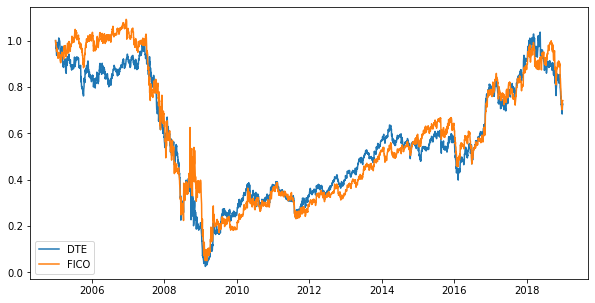

In [19]:
# Plotting the top pair to see the price chart
i, j, _ = top_pairs[0]
i = tickers.index(i)
j = tickers.index(j)

plt.figure(figsize=(10,5))
plt.plot(data_train[i]['Close'], label=tickers[i])
plt.plot(data_train[j]['Close'], label=tickers[j])
plt.legend()
plt.show()

# Coding the logic for pairs trading strategy

In [20]:
# Calculating the spread for each pair of stocks
spread_train = [data_train[tickers.index(i)]['Close'] - data_train[tickers.index(j)]['Close'] for i,j,_ in top_pairs]
std_spread = [np.std(s) for s in spread_train]

spread = [data_test[tickers.index(i)]['Close'] - data_test[tickers.index(j)]['Close'] for i,j,_ in top_pairs]

In [22]:
# Generating the signal for each pair based on standard deviation +/- 2 thresholds
signals = [np.where(s > 2 * std, 1, np.where(s < -2 * std, -1, 0)) for s, std in zip(spread, std_spread)]

In [23]:
# Calculating the daily returns for each pair of stocks
returns = []

for i, j, _ in top_pairs:
    signal = signals[top_pairs.index((i, j, _))]
    i_index = tickers.index(i)
    j_index = tickers.index(j)
    returns.append([])
    
    for k in range(len(signal)):
        return_ = 0
        
        # If the signal is 1 and the previous signal is not 1, then short the first stock and long the second stock
        if signal[k] == 1 and (k == 0 or signal[k - 1] != 1):
            
            # Exit the position when the spread is less than or equal to 0
            exit = k + np.argmax(spread[top_pairs.index((i, j, _))][k:] <= 0)
            
            # Handle the case when the exit is the last day of the data
            if exit == len(spread[top_pairs.index((i, j, _))]) - 1:
                return_ = (data_test[j_index]['Close'].iloc[-1] / data_test[j_index]['Open'].iloc[k+1] - 1) - (data_test[i_index]['Close'].iloc[-1] / data_test[i_index]['Open'].iloc[k+1] - 1)
            else:
                return_ = (data_test[j_index]['Close'].iloc[exit+1] / data_test[j_index]['Open'].iloc[k+1] - 1) - (data_test[i_index]['Close'].iloc[exit+1] / data_test[i_index]['Open'].iloc[k+1] - 1)
            
            return_ = float(return_)
            
        # If the signal is -1 and the previous signal is not -1, then long the first stock and short the second stock
        elif signal[k] == -1 and (k == 0 or signal[k - 1] != -1):
            
            # Exit the position when the spread is greater than or equal to 0
            exit = k + np.argmax(spread[top_pairs.index((i, j, _))][k:] >= 0)
            
            # Handle the case when the exit is the last day of the data
            if exit == len(spread[top_pairs.index((i, j, _))]) - 1:
                return_ = (data_test[i_index]['Close'].iloc[-1] / data_test[i_index]['Open'].iloc[k] - 1) - (data_test[j_index]['Close'].iloc[-1] / data_test[j_index]['Open'].iloc[k] - 1)
            else:
                return_ = (data_test[i_index]['Close'].iloc[exit+1] / data_test[i_index]['Open'].iloc[k+1] - 1) - (data_test[j_index]['Close'].iloc[exit+1] / data_test[j_index]['Open'].iloc[k+1] - 1)

            return_ = float(return_)

        returns[-1].append(return_)
        
# Calculating the cumulative return for each pair of stocks
cumulative_returns = [np.cumsum(r) for r in returns]

In [25]:
# Calculating the sharpe ratio for each pair of stocks
sharpe_ratios = [np.mean(r) / np.std(r) * np.sqrt(252) for r in returns if np.std(r) != 0]
sharpe_ratios_pairs = [(i, j, r) for (i, j, _), r in zip(top_pairs, sharpe_ratios)]

sharpe_ratios_pairs = sorted(sharpe_ratios_pairs, key=lambda x: x[2], reverse=True)
sharpe_ratios_pairs

[('GOOG', 'NDSN', 2.705578329413756),
 ('CPAY', 'ELV', 2.6664013891111384),
 ('ALGN', 'GOOG', 2.6340556146485072),
 ('MET', 'PGR', 2.4143081754821782),
 ('GEHC', 'NKE', 2.194519535915568),
 ('GE', 'HAL', 2.1815520432032485),
 ('ADSK', 'ORCL', 2.031158291089858),
 ('PH', 'QCOM', 1.9882150736487396),
 ('KMX', 'LW', 1.9772353480729479),
 ('CAT', 'LIN', 1.9618253202499247),
 ('GOOG', 'HUM', 1.8993049478387993),
 ('LEN', 'PKG', 1.6928873492337513),
 ('NI', 'PGR', 1.6553565963635306),
 ('DOW', 'HES', 1.654034427913447),
 ('CMCSA', 'CEG', 1.6293604034765203),
 ('FICO', 'META', 1.6125733401813704),
 ('CPAY', 'HRL', 1.5866724276844033),
 ('ATO', 'META', 1.503698930226668),
 ('GOOG', 'CDNS', 1.5030116076018027),
 ('ED', 'HRL', 1.496974433373055),
 ('GD', 'META', 1.4557300667185686),
 ('DTE', 'MMC', 1.3854254320217616),
 ('PH', 'QRVO', 1.349007661479881),
 ('DTE', 'GE', 1.3144660440973435),
 ('KKR', 'PEG', 1.1917296821985315),
 ('BMY', 'ELV', 1.1663456925493578),
 ('FICO', 'GD', 1.145738255726211

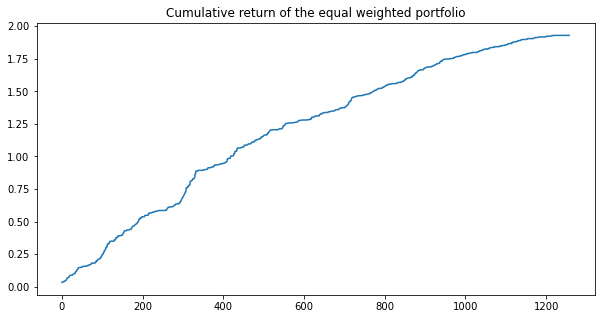

Sharpe ratio of the equal weighted portfolio: 2.1541948838886547


In [33]:
# Calculating the sharpe ratio of a equal weighted portfolio
cumulative_returns_portfolio = np.sum(cumulative_returns, axis=0) / 50
sharpe_ratio_portfolio = np.mean(cumulative_returns_portfolio) / np.std(cumulative_returns_portfolio)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns_portfolio)
plt.title('Cumulative return of the equal weighted portfolio')
plt.show()

print(f'Sharpe ratio of the equal weighted portfolio: {sharpe_ratio_portfolio}')

# Cointegration as an Alternate Approach

In [45]:
def find_cointegrated_pairs(data):
    n = len(data)

    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))

    keys = range(n)
    pairs = list(itertools.combinations(keys, 2))

    for i, j in pairs:
        print(f'Finding cointegration for {tickers[i]} and {tickers[j]}')
        try:
            result = coint(data[i]['Close'], data[j]['Close'])
        except:
            print(f'Error in cointegration test for {tickers[i]} and {tickers[j]}')
            continue
        else:
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue

    return score_matrix, pvalue_matrix

In [ ]:
score_matrix, pvalue_matrix = find_cointegrated_pairs(holder)

In [ ]:
pairs = []

for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        
        if pvalue_matrix[i, j] < 0.05:
            pairs.append((tickers[i], tickers[j]))

print (f'Found {len(pairs)} cointegrated pairs')

In [ ]:
# Print the top 100 cointegrated pairs with the lowest p-values
pairs.sort(key=lambda x: pvalue_matrix[tickers.index(x[0]), tickers.index(x[1])])

for pair in pairs[:100]:
    print(pair, pvalue_matrix[tickers.index(pair[0]), tickers.index(pair[1])])